In [95]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.layouts import widgetbox
from bokeh.models.widgets import DataTable, NumberFormatter, TableColumn
output_notebook()
from collections import defaultdict
from k_fold import cross_validation
from proj1_helpers import *
from implementations import *
from helpers import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [68]:
y, x, ids = load_csv_data('data/train.csv')
labels = np.array(np.genfromtxt('data/train.csv', delimiter=",", names=True).dtype.names[2:])
n = x.shape[0]
dimensionality = x.shape[1]

In [91]:
for name in labels[[0, 1, 2, 3, 5, 8, 9, 10, 13, 19, 21, 23, 26, 29]]:
    print(name.replace('_', '\_'), end=', ')

DER\_mass\_MMC, DER\_mass\_transverse\_met\_lep, DER\_mass\_vis, DER\_pt\_h, DER\_mass\_jet\_jet, DER\_pt\_tot, DER\_sum\_pt, DER\_pt\_ratio\_lep\_tau, PRI\_tau\_pt, PRI\_met, PRI\_met\_sumet, PRI\_jet\_leading\_pt, PRI\_jet\_subleading\_pt, PRI\_jet\_all\_pt, 

# Data exploration

In [92]:
def describe(x, labels):
    data = x.copy()
    data[data==-999] = np.nan
    data = {
        'Label':labels,
        'Min':np.nanmin(data,axis=0),
        'Q1':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Q3':np.nanpercentile(data, 75, interpolation='midpoint', axis=0),
        '.95 perc.':np.nanpercentile(data, 95, interpolation='midpoint', axis=0),
        'Max':np.nanmax(data,axis=0),
        'Median':np.nanmedian(data,axis=0),
        'Mean':np.nanmean(data,axis=0),
        'Std':np.nanstd(data,axis=0),
        'Missing': np.sum(np.isnan(data),axis=0)
    }
    numberFormatter =  NumberFormatter(format='0.000')
    source = ColumnDataSource(data)
    label_colum = TableColumn(field='Label', title='Label', width=150)
    columns = [label_colum] + [TableColumn(field=label, title=label, formatter=numberFormatter, width=100)\
                for label in [k for k in data.keys() if k != 'Label']]
    data_table = DataTable(source=source, columns=columns, width=900, height = 800)
    show(widgetbox(data_table, sizing_mode = 'scale_both'))

In [96]:
describe(x, labels)

In [80]:
for i in range(6):
    x_group, y_group, mask = get_group(x, y, i, True)
    describe(x_group, labels[mask])

In [47]:
def correlation(y, x, mask=np.ones(labels.shape[0], dtype=bool)):
    labels_masked = labels[mask]
    complete_data = np.c_[y,x]
    corr  = np.corrcoef(complete_data.T)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    xticks = np.append('Boson',labels_masked)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=xticks, yticklabels=xticks)
    plt.plot()

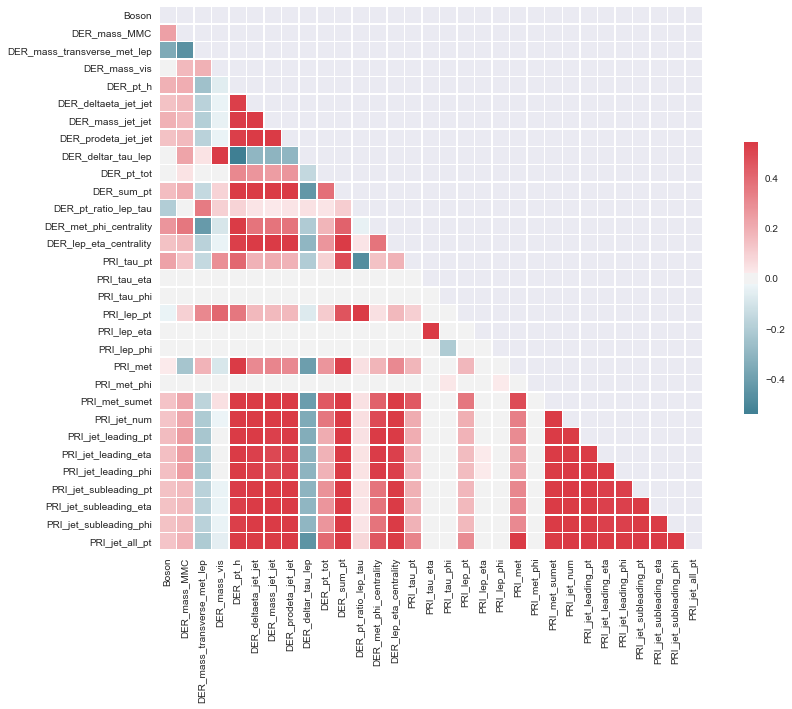

In [50]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [15.0,10.0]
correlation(y, x)
plt.rcParams["figure.figsize"] = fig_size

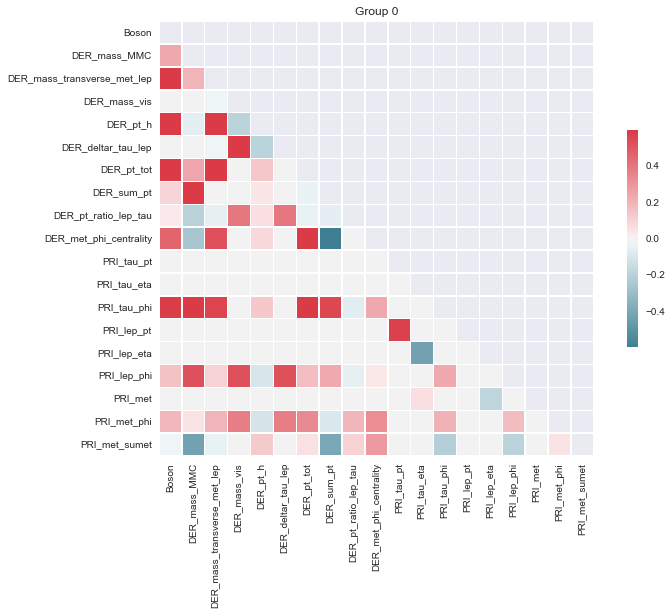

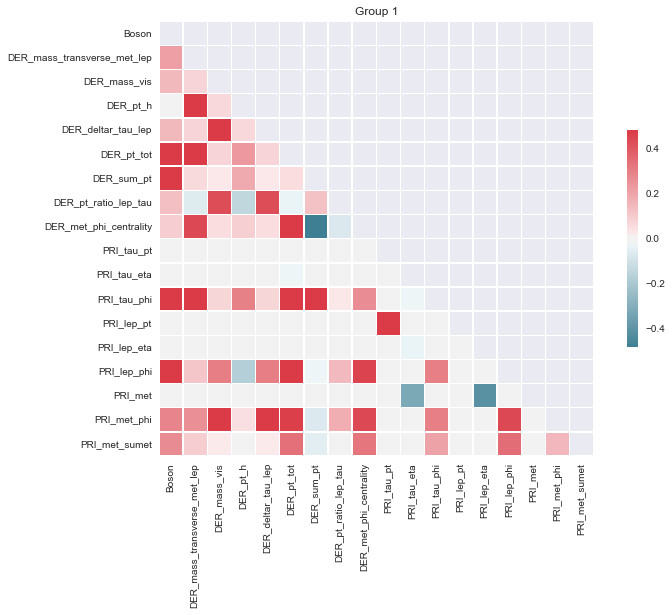

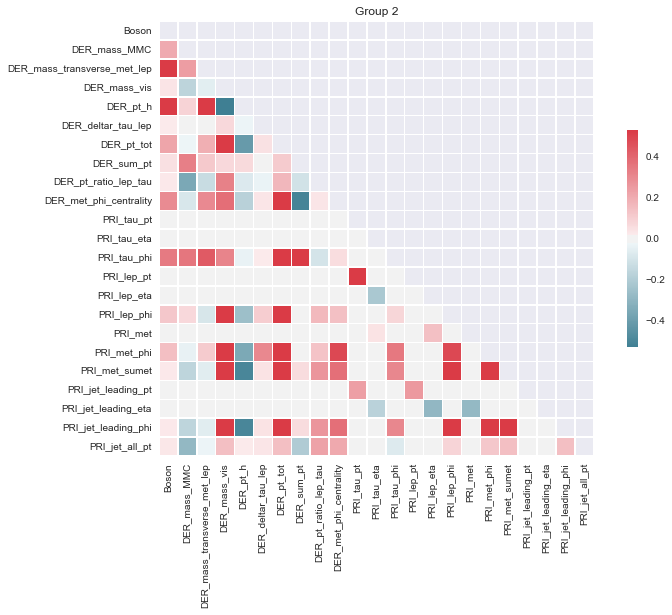

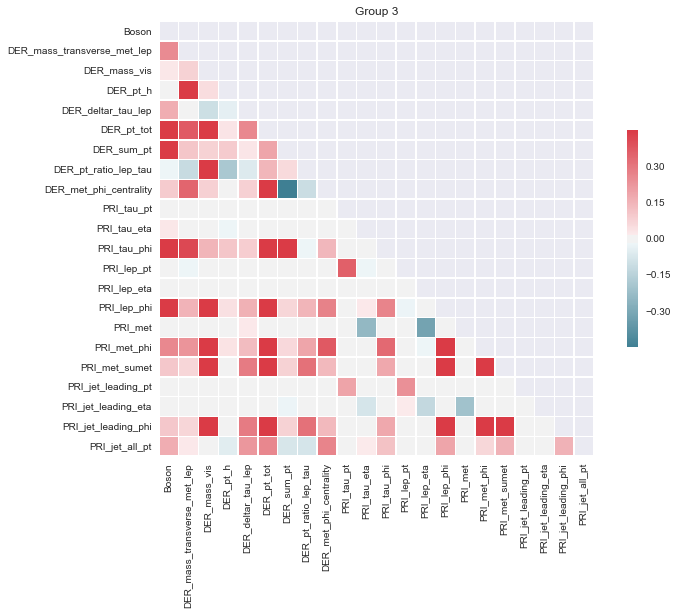

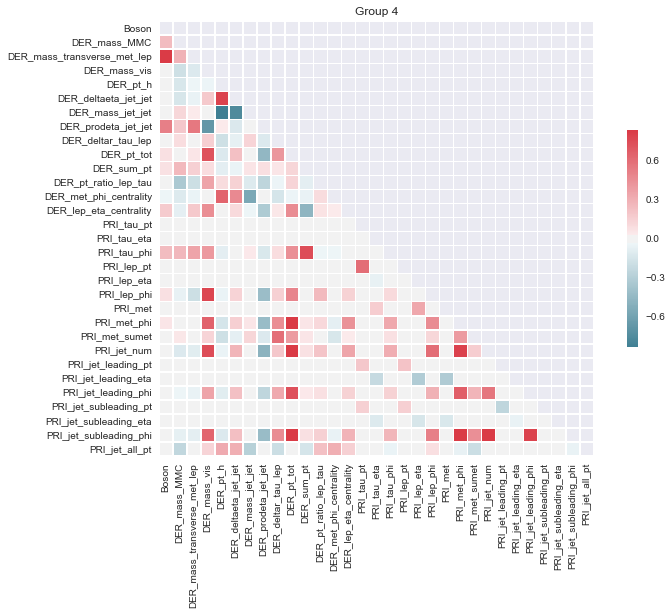

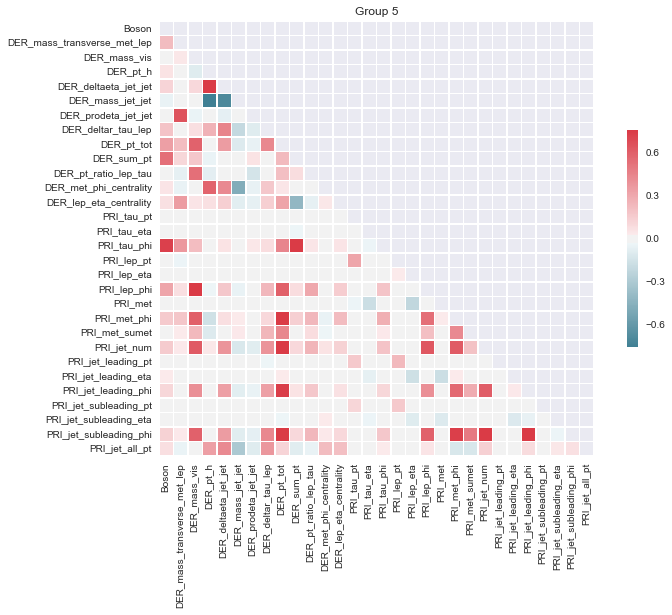

In [46]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [12.0,8.0]
for i in range(6):
    plt.figure(i)
    correlation(*get_group(x , y, i, True))
    plt.title('Group ' + str(i))
plt.rcParams["figure.figsize"] = fig_size

We'll begin the analysis by observing the distribution of the invalid entries, i.e. the fields which take value -999. This distribution can be analyzed on two dimensions: features or data-samples - in another word column and lines.
Let's begin by checking the number of invalid entries per feature.

In [4]:
#this function returns the number of invalid entry for a given feature
def quantify_invalid_entries(feature):
    number_invalid_values = feature[feature == -999].shape[0]
    return number_invalid_values

#this functions returns a dict containg key-value tuples (feature_name, invalid_entries_per_feature)
def invalid_entries_per_feature():
    invalid_entries = {}
    for feature in range(dimensionality):
        invalid_entries[labels[feature]] = quantify_invalid_entries(x[:,feature])
    
    return invalid_entries
                               
invalid_entries_per_feature()

{'DER_deltaeta_jet_jet': 177457,
 'DER_deltar_tau_lep': 0,
 'DER_lep_eta_centrality': 177457,
 'DER_mass_MMC': 38114,
 'DER_mass_jet_jet': 177457,
 'DER_mass_transverse_met_lep': 0,
 'DER_mass_vis': 0,
 'DER_met_phi_centrality': 0,
 'DER_prodeta_jet_jet': 177457,
 'DER_pt_h': 0,
 'DER_pt_ratio_lep_tau': 0,
 'DER_pt_tot': 0,
 'DER_sum_pt': 0,
 'PRI_jet_all_pt': 0,
 'PRI_jet_leading_eta': 99913,
 'PRI_jet_leading_phi': 99913,
 'PRI_jet_leading_pt': 99913,
 'PRI_jet_num': 0,
 'PRI_jet_subleading_eta': 177457,
 'PRI_jet_subleading_phi': 177457,
 'PRI_jet_subleading_pt': 177457,
 'PRI_lep_eta': 0,
 'PRI_lep_phi': 0,
 'PRI_lep_pt': 0,
 'PRI_met': 0,
 'PRI_met_phi': 0,
 'PRI_met_sumet': 0,
 'PRI_tau_eta': 0,
 'PRI_tau_phi': 0,
 'PRI_tau_pt': 0}

In [5]:
def get_variable_domain(dic):
    grouped_dic = defaultdict(list)
    for v, k in dic.items(): 
        grouped_dic[k].append(v)
    return grouped_dic.keys()

get_variable_domain(invalid_entries_per_feature())

dict_keys([0, 177457, 38114, 99913])

We notice that the number of invalid entries per feature is a discrete variable, whose set of possible realizations is {0, 38114, 99913, 177457}. This hints at a potential strong correlation between the features having the same number of invalid entries. I'll verify this hypothesis with a correlation matrix.

In [6]:
complete_data = np.append(np.array([y]).T,x,axis=1)
corr  = np.corrcoef(complete_data.T)
corr[:,0]
filter_ = [idx for idx, label in enumerate(labels) if not 'phi' in label]
x[:, filter_].shape

(250000, 24)

/Users/Hakim/anaconda/lib/python3.5/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/Hakim/anaconda/lib/python3.5/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


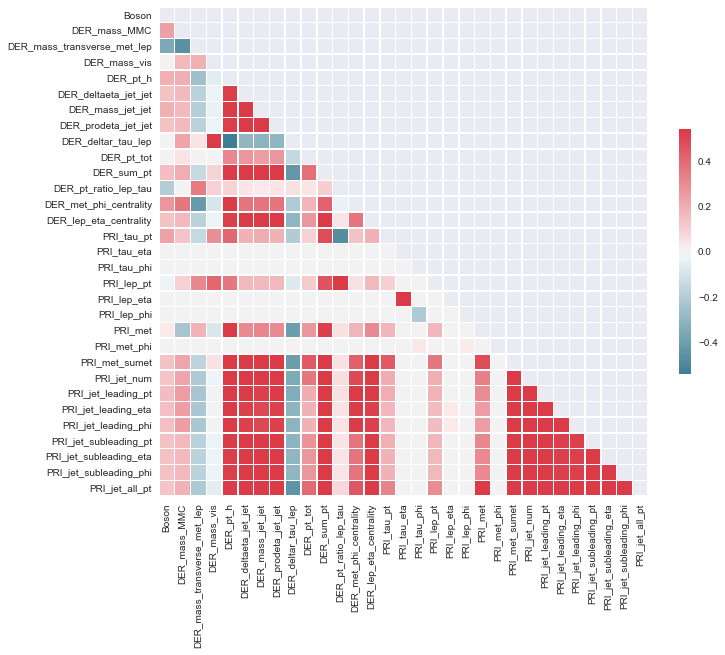

In [7]:
complete_data = np.append(np.array([y]).T,x,axis=1)
corr  = np.corrcoef(complete_data.T)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
xticks = np.append('Boson',labels)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=xticks, yticklabels=xticks);

Some features show to be very correlated to many other features, therefore they could be removed since they don't add useful information.

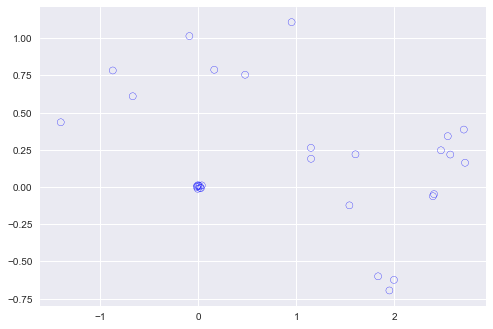

In [8]:
x_no = x.copy()
x_no[x_no == -999] = 0.0
corr = np.corrcoef(x_no.T)
eigenvalues, eigenvectors = la.eigh(corr)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
projection_s = corr.dot(eigenvectors[:,:4])
plt.scatter(projection_s[:,0],projection_s[:,1],facecolors='none',edgecolors='b')
# projection_b = corr.dot(eigenvectors[:,:4])
# plt.scatter(projection_b[:,0],projection_b[:,1],facecolors='none',edgecolors='g')

In [9]:
#compute correlation vector between each feature in X and the output y
def compute_correlation_vector(x, y):
    x = x.copy()
    dimensionality = x.shape[1]
    x[x == -999] = np.nan
    correlation_vector = np.zeros(dimensionality)
    for feature in range(dimensionality):
        correlation_vector[feature] = np.corrcoef(x[:, feature], y)[0,1]
    return correlation_vector

def compute_correlation_matrix(x):
    y = x.copy()
    dimensionality = y.shape[1]
    y[y == -999] = 0
    correlation_matrix = np.zeros((dimensionality, dimensionality))
                                  
    for first_feature in range(dimensionality):
        for second_feature in range(dimensionality):
        # i take element [0,1] of the Pearson correlation matrix, which corresponds 
        # to the correlation between feature and output.
            correlation_matrix[first_feature, second_feature] = np.corrcoef(y[:, first_feature], y[:, second_feature])[0,1]
    return correlation_matrix

In [10]:
compute_correlation_matrix(x)

array([[  1.00000000e+00,  -1.71891563e-01,   6.58958616e-01,
          1.43550100e-01,   8.73681532e-02,   7.31887221e-02,
         -2.77985087e-02,   4.54145391e-01,   3.79598740e-02,
          2.10712639e-01,   3.42657510e-02,   2.44079579e-01,
          7.62145156e-02,   2.56039065e-01,   3.28780778e-03,
         -5.93010824e-03,   2.82278060e-01,   8.68835745e-03,
         -2.50889544e-03,  -8.78713687e-02,   4.72332685e-03,
          1.99828034e-01,   1.52051278e-01,   1.36548909e-01,
          1.45741596e-03,   2.06041377e-03,   9.34343219e-02,
          1.20972991e-03,  -2.53579134e-03,   1.26652504e-01],
       [ -1.71891563e-01,   1.00000000e+00,   1.90109488e-01,
         -2.49115929e-01,  -1.81807639e-01,  -1.66374960e-01,
          1.00320136e-01,   4.32514093e-02,   1.77575270e-02,
         -1.46836679e-01,   3.49503614e-01,  -4.19757335e-01,
         -1.65878018e-01,  -1.45464145e-01,  -2.10917148e-03,
          1.13208392e-03,   3.10647518e-01,  -6.77706784e-03,
       

In [11]:
#PROBLEM: Matrix is unreadable. How to comment?

Let's now check the number of invalid entries per data-sample.

In [12]:
def invalid_entries_per_sample(x):
    invalid_entries = {}
    for sample in range(5000):
        invalid_entries[sample] = quantify_invalid_entries(x[sample, :])
    
    return invalid_entries
                               
invalid_entries_per_sample(x)

{0: 0,
 1: 7,
 2: 8,
 3: 10,
 4: 10,
 5: 0,
 6: 0,
 7: 7,
 8: 10,
 9: 7,
 10: 11,
 11: 0,
 12: 7,
 13: 10,
 14: 11,
 15: 10,
 16: 7,
 17: 10,
 18: 11,
 19: 11,
 20: 11,
 21: 10,
 22: 10,
 23: 0,
 24: 10,
 25: 10,
 26: 7,
 27: 0,
 28: 7,
 29: 0,
 30: 8,
 31: 0,
 32: 0,
 33: 0,
 34: 7,
 35: 7,
 36: 10,
 37: 10,
 38: 0,
 39: 0,
 40: 10,
 41: 10,
 42: 0,
 43: 10,
 44: 10,
 45: 0,
 46: 0,
 47: 10,
 48: 10,
 49: 10,
 50: 7,
 51: 0,
 52: 11,
 53: 11,
 54: 10,
 55: 10,
 56: 1,
 57: 0,
 58: 10,
 59: 0,
 60: 0,
 61: 10,
 62: 7,
 63: 10,
 64: 7,
 65: 7,
 66: 10,
 67: 10,
 68: 0,
 69: 10,
 70: 0,
 71: 11,
 72: 7,
 73: 10,
 74: 11,
 75: 10,
 76: 10,
 77: 0,
 78: 0,
 79: 7,
 80: 10,
 81: 8,
 82: 0,
 83: 0,
 84: 0,
 85: 11,
 86: 7,
 87: 10,
 88: 7,
 89: 7,
 90: 0,
 91: 10,
 92: 10,
 93: 0,
 94: 7,
 95: 10,
 96: 10,
 97: 0,
 98: 0,
 99: 0,
 100: 7,
 101: 0,
 102: 0,
 103: 0,
 104: 10,
 105: 0,
 106: 0,
 107: 0,
 108: 10,
 109: 7,
 110: 7,
 111: 0,
 112: 10,
 113: 7,
 114: 10,
 115: 10,
 116: 11,
 117:

In [13]:
get_variable_domain(invalid_entries_per_sample(x))

dict_keys([0, 1, 7, 8, 10, 11])

Apparently the number of invalid entries per data sample can be modelized as a random variable whose sample space is the set {0,1,7,8,10,11}. 
We noticed that there's a discrete feature, feature 22 or "PRI_jet_num", which is also a random variable with sample space S = {0,1,2,3}. 
Let's see if there's a relation between these two discrete random variables.

In [14]:
def get_index(value):
    index = (x[:, 22] == value)
    return index

jet_num_0 = get_index(0)
jet_num_1 = get_index(1)
jet_num_2 = get_index(2)
jet_num_3 = get_index(3)

In [15]:
get_variable_domain(invalid_entries_per_sample(x[jet_num_0]))

dict_keys([10, 11])

In [16]:
get_variable_domain(invalid_entries_per_sample(x[jet_num_1]))

dict_keys([8, 7])

In [17]:
get_variable_domain(invalid_entries_per_sample(x[jet_num_2]))

dict_keys([0, 1])

In [18]:
get_variable_domain(invalid_entries_per_sample(x[jet_num_3]))

dict_keys([0, 1])

The analysis allows us to conclude that there's a strong correlation between the two random variables.
To be more formal:

if the number of invalid features takes values in {10,11}, then JET_pri_num takes value 0. (Group 0)

if the number of invalid features takes values in {7,8}, then JET_pri_num takes value 1. (Group 1)

if the number of invalid features takes values in {0,1}, then JET_pri_num takes value in {2,3}. (Group 2)

This is a possible division of the training set. 

However, it's still interesting to remark that the three realization sets associated to each group, i.e. {10,11}, {7,8} and {0,1}, each contain values that are just one unit apart.
Further observation of the data leads to the conclusion that the feature which determines the number of invalid entry per sample in each group is feature 0 called DER_mass_MMC. 

Example: if we are in group 0 and and feature 0's entry is valid, then the number of invalid entry per sample is 10.

This leads to an even better group division:

if JET_pri_num = 0 and DER_mass_MMC is valid, then the number of invalid features per sample is 10. (Group 0)

if JET_pri_num = 0 and DER_mass_MMC is invalid, then the number of invalid features per sample is 11. (Group 1)

if JET_pri_num = 1 and DER_mass_MMC is valid, then the number of invalid features per sample is 7. (Group 2)

if JET_pri_num = 1 and DER_mass_MMC is invalid, then the number of invalid features per sample is 8. (Group 3)

if JET_pri_num = 2 or JET_pri_num = 3 and DER_mass_MMC is valid, then the number of invalid features per sample is 0. (Group 4)

if JET_pri_num = 2 or JET_pri_num = 3 and DER_mass_MMC is invalid, then the number of invalid features per sample is 1. (Group 5)

This division in six groups is the one we will use in our model.

In [19]:
def summary_table(data):
    data = data.copy()
    data[data==-999] = np.nan
    data = {
        'Label':labels,
        'Min':np.nanmin(data,axis=0),
        'Q1':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Q3':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Max':np.nanmax(data,axis=0),
        'Median':np.nanmedian(data,axis=0),
        'Mean':np.nanmean(data,axis=0),
        'Std':np.nanstd(data,axis=0),
        'Missing': np.count_nonzero(np.isnan(data),axis=0)/data.shape[0]
    }
    numberFormatter =  NumberFormatter(format='0.000')
    source = ColumnDataSource(data)
    label_colum = TableColumn(field='Label', title='Label', width=150)
    columns = [label_colum] + [TableColumn(field=label, title=label, formatter=numberFormatter, width=80)\
               for label in [k for k in data.keys() if k != 'Label']]
    data_table = DataTable(source=source, columns=columns, width=900, height = 800)
    show(widgetbox(data_table, sizing_mode = 'scale_both'))
    
summary_table(x)

Here's some stastical data for each feature.

In [76]:
def density_plot(y, x, labels):
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [18,40]
    for i, label in enumerate(labels):
        plt.subplot(10,3,i+1)
        values_s = x[y == 1]
        values_s = values_s[:,i]
        values_s[values_s==-999] = np.nan 
    #     plt.hist(values_s[~np.isnan(values_s)], label='s', histtype='step')
        sns.kdeplot(values_s[~np.isnan(values_s)], label='s', bw=0.1)

        values_b = x[y == -1]
        values_b = values_b[:,i]
        values_b[values_b==-999] = np.nan
    #     plt.hist(values_b[~np.isnan(values_b)], label='b', histtype='step')
        sns.kdeplot(values_b[~np.isnan(values_b)], label='b',bw=0.1)
        plt.title(label)
        plt.ylabel('Density')
        plt.xlabel('Value')
    plt.tight_layout()
    plt.rcParams["figure.figsize"] = fig_size

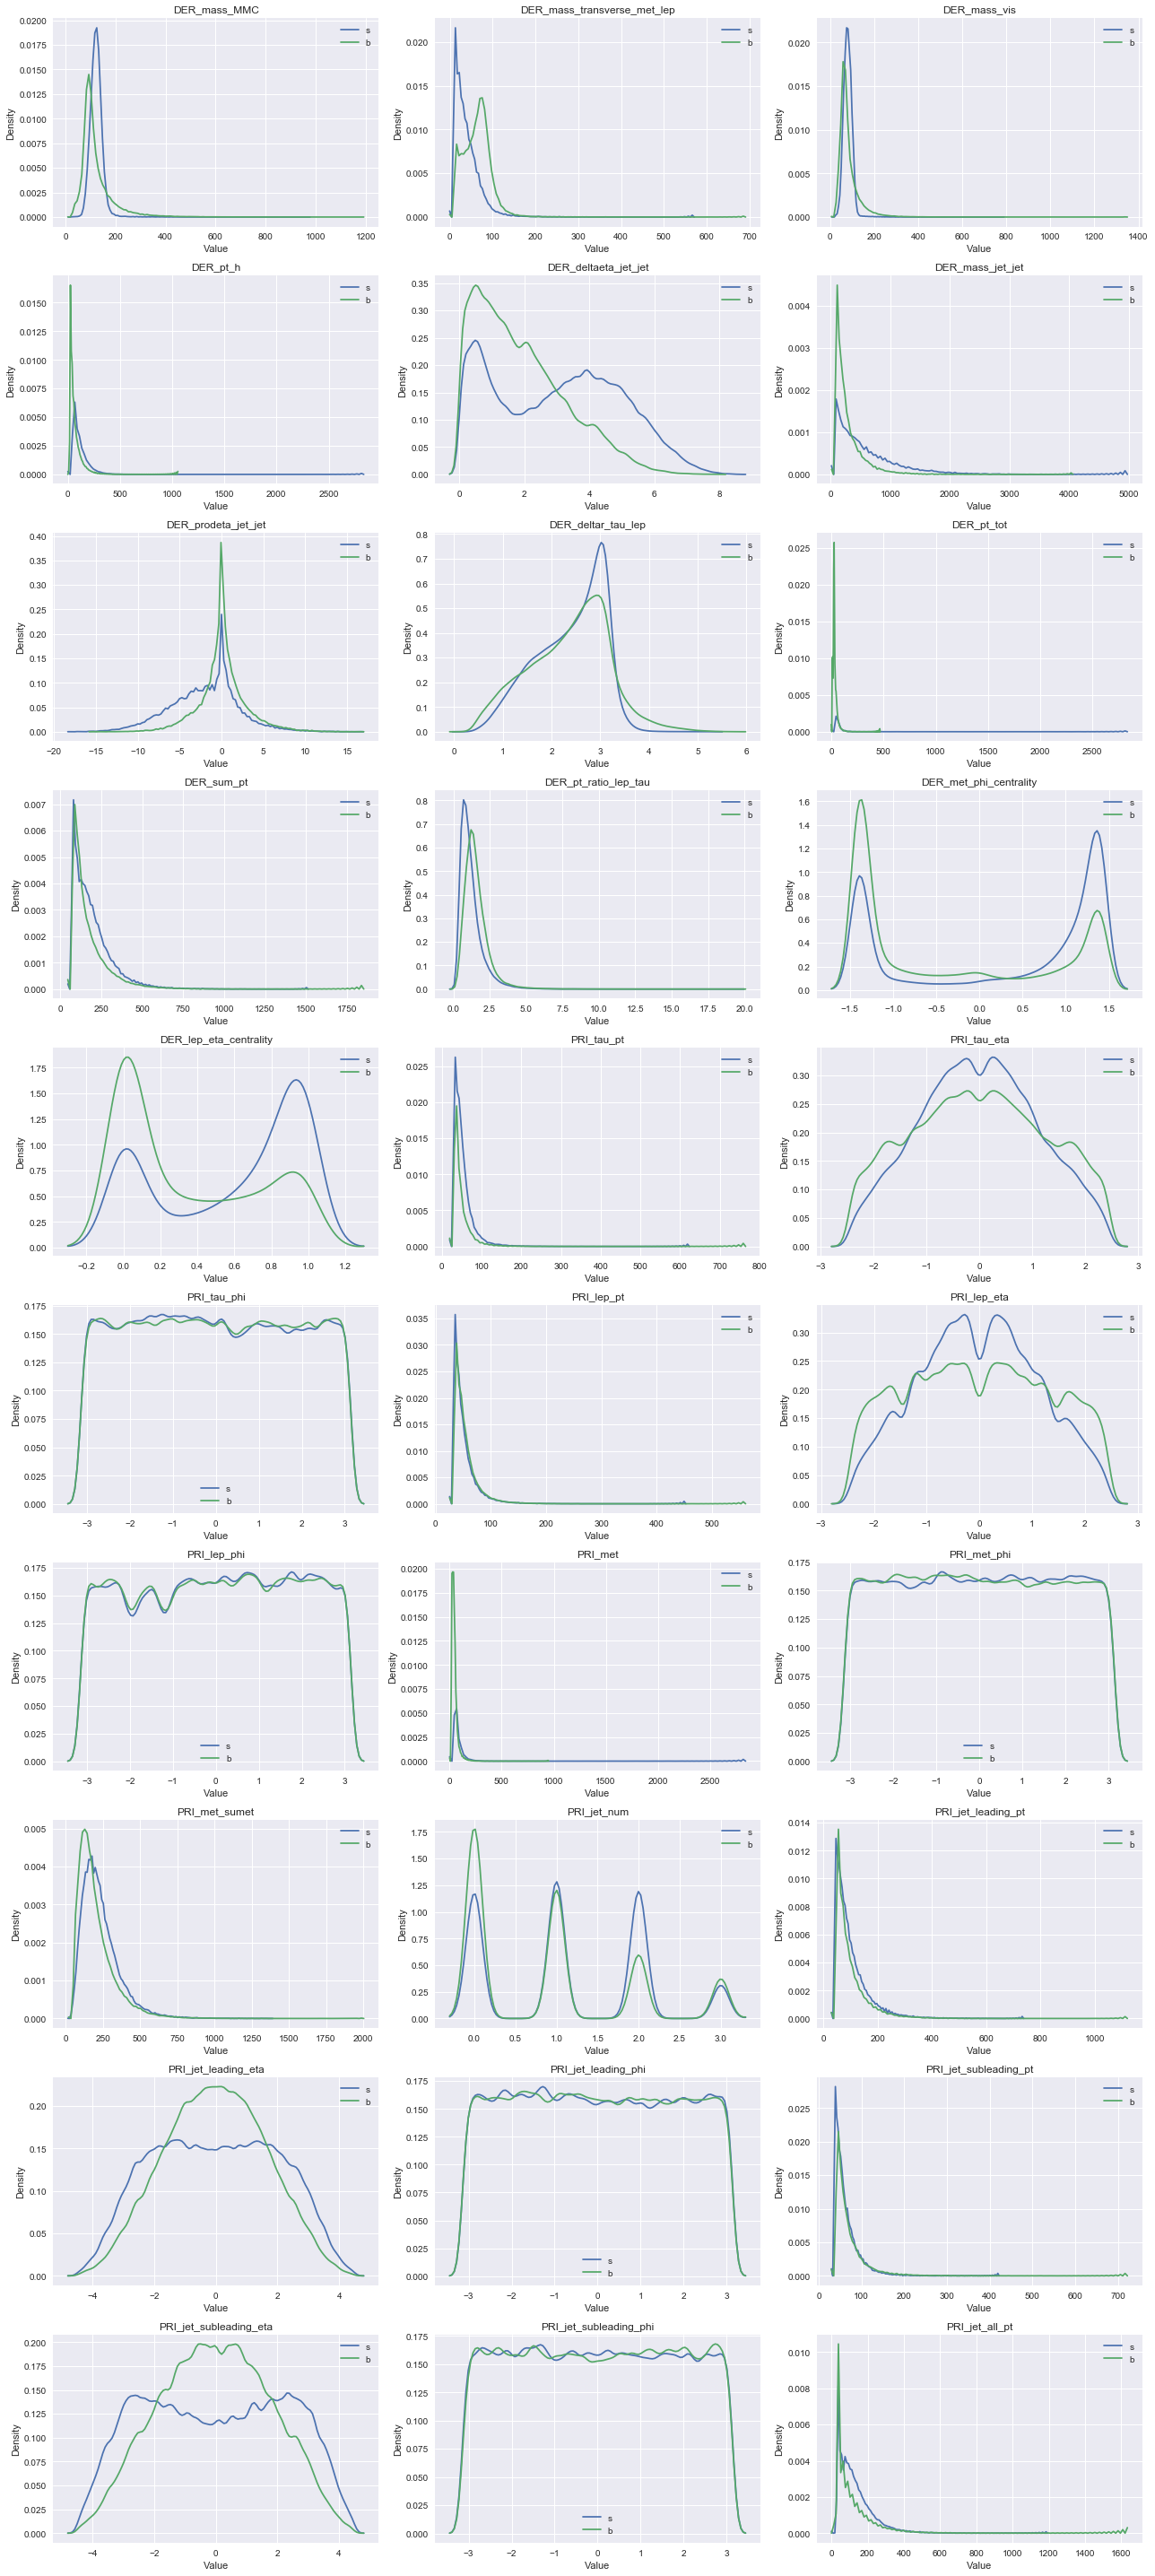

In [77]:
density_plot(y, x, labels)

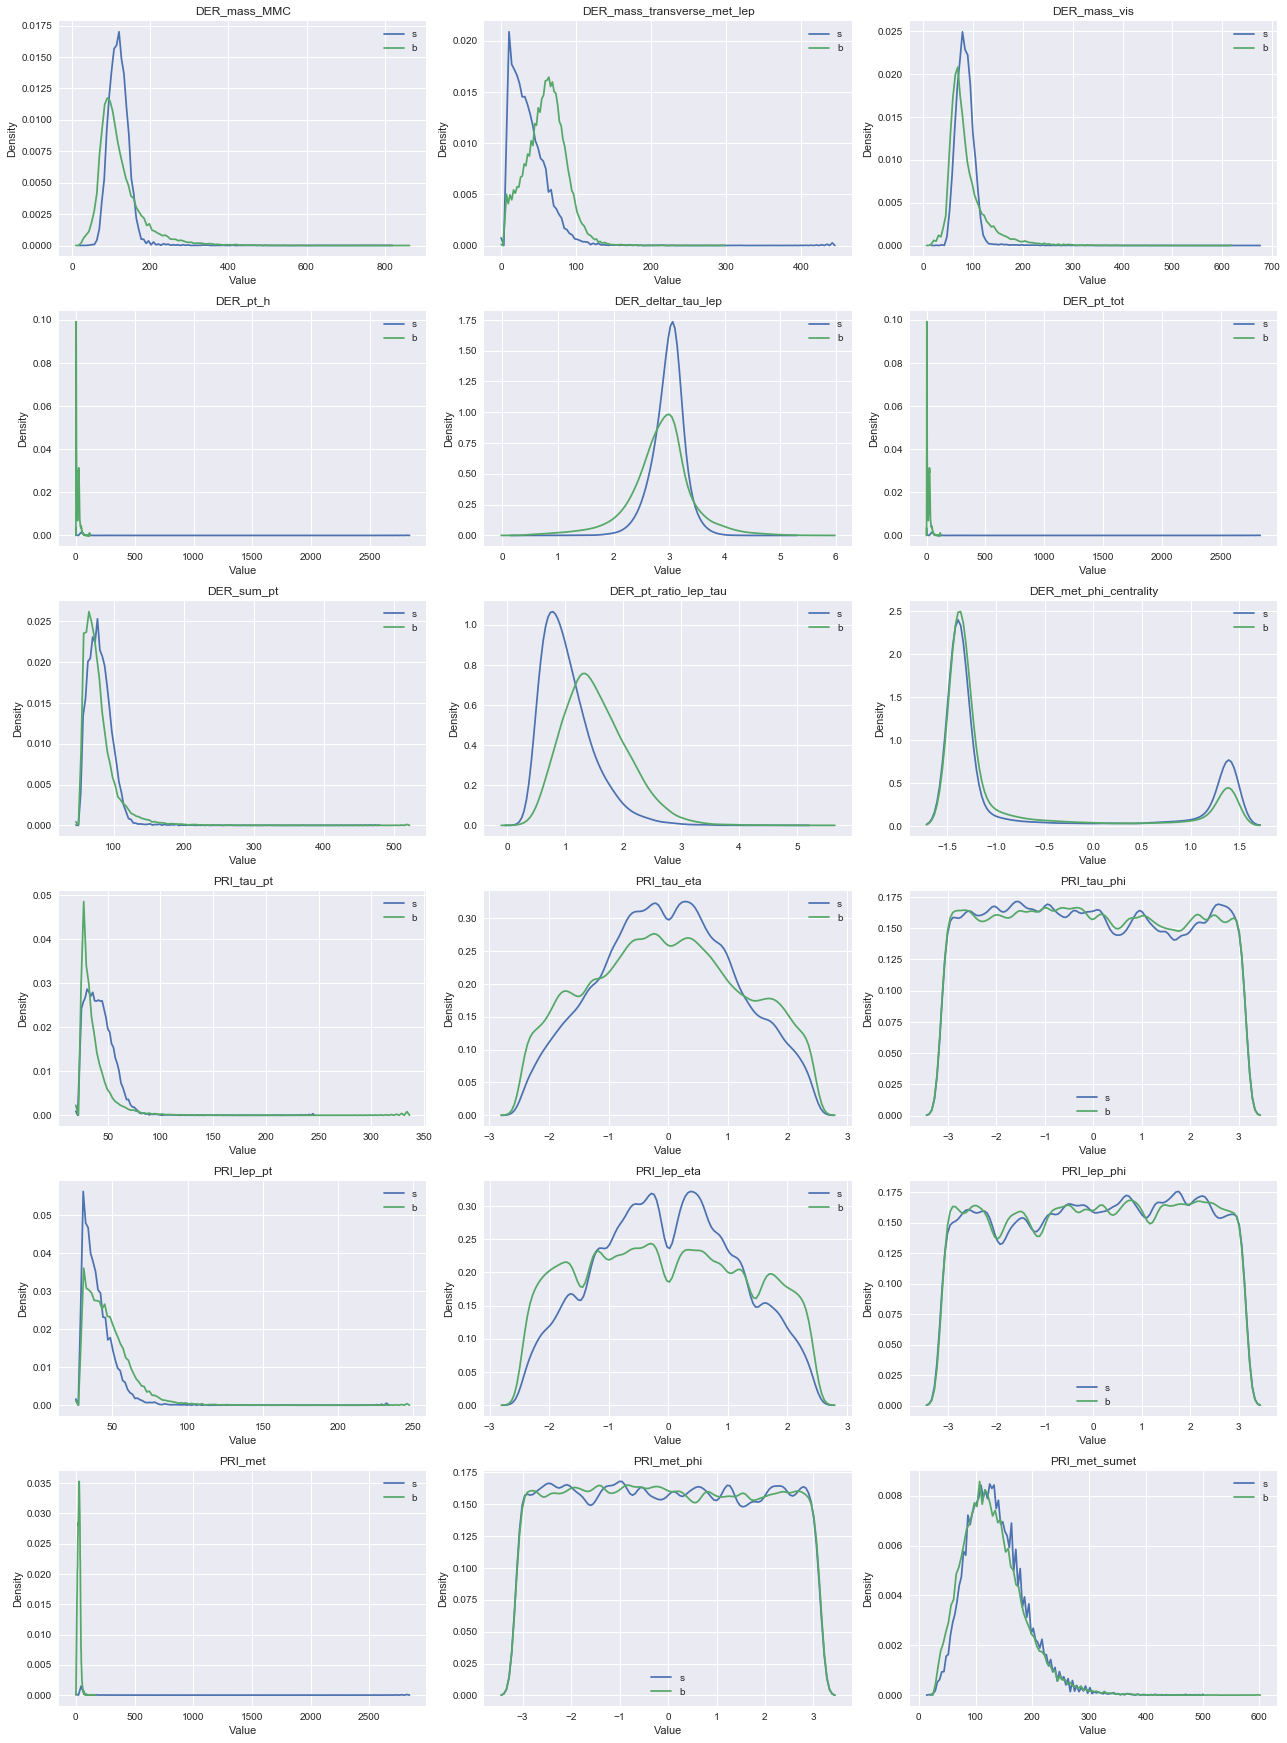

In [83]:
x_group, y_group, mask = get_group(x, y, 0, True)
density_plot(y_group, x_group, labels[mask])

# Conclusion

Features 15, 18, 20, 25 and 28 follow an uniform distribution independently of the  s-b classification. 
This means that the classification is equiprobable, therefore the data isn't useful as training data and should be discarded.

Features 0, 1, 2, 3, 5, 8, 9, 10, 13, 19, 21, 23, 26, 29 follow an exponential distribution. They will be standardized with the function described below for better performance.

In [ ]:
def log_normalize(x):
    if x > 0:
        return np.log(x)
    return x
normalize = [idx for idx, label in enumerate(labels) if label in ['DER_mass_vis', 'PRI_tau_pt', 'PRI_lep_pt',\
                                                                  'PRI_met', 'PRI_jet_subleading_pt', 'DER_mass_MMC',\
                                                                  'DER_mass_vis', 'DER_pt_tot', 'DER_sum_pt',\
                                                                  'DER_pt_ratio_lep_tau', 'PRI_met_sumet',\
                                                                  'PRI_jet_leading_pt']]